In [ ]:
# This notebook has been run on Google Colab. To run it, uncomment the following lines

# !rm -r Few-shot-learning-with-HuBERT
# !git clone -b add-finetuning-for-animal-dataset --single-branch \
# https://github.com/luckyman94/Few-shot-learning-with-HuBERT.git

# !pip install -U kagglehub

rm: cannot remove 'Few-shot-learning-with-HuBERT': No such file or directory
Cloning into 'Few-shot-learning-with-HuBERT'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 232 (delta 92), reused 206 (delta 66), pack-reused 0 (from 0)
Receiving objects: 100% (232/232), 4.18 MiB | 10.64 MiB/s, done.
Resolving deltas: 100% (92/92), done.
rm: cannot remove 'kagglehub_cache/': No such file or directory


In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import sys
from pathlib import Path
from collections import Counter
from peft import LoraConfig, get_peft_model
import os

# ---- Hugging Face token ----
# Uncomment the following line if you want to run the notebook on Google Colab. Make sure to replace "YOUR
#os.environ["HF_TOKEN"] = "YOUR TOKEN HERE"

# Uncomment the following lines if you want to run the notebook on Google Colab
#ROOT = Path.cwd() / "Few-shot-learning-with-HuBERT"
#sys.path.append(str(ROOT))

assert "HF_TOKEN" in os.environ
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.evaluation.confusion import plot_confusion_matrix
from src.evaluation.metrics import classification_metrics
from transformers import HubertModel
from src.datasets.bird_dog_cat import AnimalAudioDataset

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from src.methods.finetuning.training import train_model
from src.methods.finetuning.inference import get_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
root_dir = "Animals"

dataset = AnimalAudioDataset(root_dir)

print("Classes :", dataset.classes)
print("Nombre total de fichiers :", len(dataset))


Using Colab cache for faster access to the 'cats-vs-dogs-vs-birds-audio-classification' dataset.
Classes : ['bird', 'cat', 'dog']
Nombre total de fichiers : 610


In [32]:
labels = [label for _, label in dataset.data]
indices = list(range(len(dataset)))
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

temp_labels = [labels[i] for i in temp_idx]


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [33]:
train_loader = DataLoader(
    Subset(dataset, train_idx),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    Subset(dataset, val_idx),
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    Subset(dataset, test_idx),
    batch_size=16,
    shuffle=False
)

In [34]:
print("Train:", Counter([labels[i] for i in train_idx]))
print("Val:  ", Counter([labels[i] for i in val_idx]))
print("Test: ", Counter([labels[i] for i in test_idx]))


Train: Counter({2: 147, 1: 145, 0: 135})
Val:   Counter({1: 31, 2: 31, 0: 29})
Test:  Counter({2: 32, 1: 31, 0: 29})


In [35]:
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960", use_safetensors=True)
hubert.eval().to(device)

for p in hubert.parameters():
    p.requires_grad = False

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

In [36]:
lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.2,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

In [37]:
hubert = get_peft_model(hubert, lora_config)
hubert.print_trainable_parameters()

trainable params: 147,456 || all params: 94,519,168 || trainable%: 0.1560


In [38]:
class HubertLoRAClassifier(nn.Module):
    def __init__(self, hubert, num_classes):
        super().__init__()
        self.hubert = hubert
        self.classifier = nn.Linear(
            hubert.config.hidden_size,
            num_classes
        )

    def forward(self, x):
        out = self.hubert.base_model(input_values=x)
        h = out.last_hidden_state
        z = h.mean(dim=1)
        return self.classifier(z)


In [39]:
model = HubertLoRAClassifier(hubert, num_classes=len(dataset.classes))
model.to(device)

HubertLoRAClassifier(
  (hubert): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): HubertModel(
        (feature_extractor): HubertFeatureEncoder(
          (conv_layers): ModuleList(
            (0): HubertGroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1-4): 4 x HubertNoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (5-6): 2 x HubertNoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
          )
        )
        (feature_projection): HubertFeatureProjection(
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tr

In [40]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

In [41]:
history = train_model(model,train_loader, val_loader, optimizer=optimizer, criterion=criterion, n_epochs=8, device=device)


Epoch 1/8


Epoch 1 | Train loss 1.0685 | Train acc 0.485 | Val acc 0.648
✓ Saved checkpoint (val acc = 0.648)

Epoch 2/8


Epoch 2 | Train loss 1.0386 | Train acc 0.670 | Val acc 0.736
✓ Saved checkpoint (val acc = 0.736)

Epoch 3/8


Epoch 3 | Train loss 0.9993 | Train acc 0.775 | Val acc 0.846
✓ Saved checkpoint (val acc = 0.846)

Epoch 4/8


Epoch 4 | Train loss 0.9527 | Train acc 0.871 | Val acc 0.934
✓ Saved checkpoint (val acc = 0.934)

Epoch 5/8


Epoch 5 | Train loss 0.8944 | Train acc 0.911 | Val acc 0.967
✓ Saved checkpoint (val acc = 0.967)

Epoch 6/8


Epoch 6 | Train loss 0.7813 | Train acc 0.925 | Val acc 0.967
✓ Saved checkpoint (val acc = 0.967)

Epoch 7/8


Epoch 7 | Train loss 0.5971 | Train acc 0.946 | Val acc 0.967
✓ Saved checkpoint (val acc = 0.967)

Epoch 8/8


Epoch 8 | Train loss 0.4235 | Train acc 0.951 | Val acc 0.978
✓ Saved checkpoint (val acc = 0.978)


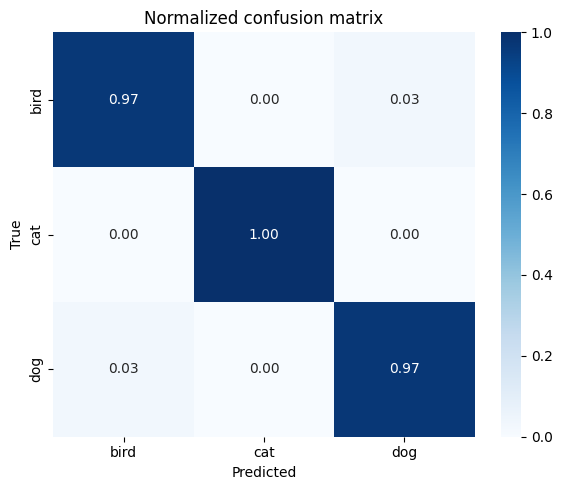

In [42]:
y_true, y_pred = get_predictions(model, test_loader, device)
plot_confusion_matrix(y_true, y_pred, class_names=dataset.classes)


In [43]:
classification_metrics(y_pred=y_pred, y_true=y_true)

{'accuracy': 0.9782608695652174,
 'f1_macro': 0.9780890804597702,
 'precision_macro': 0.9780890804597702,
 'recall_macro': 0.9780890804597702}